Activate the package and import the required dependencies

In [1]:
using Pkg
Pkg.activate("/Users/arvind/main/programs/devpackages/SafeSelfTriggered.jl")

using SafeSelfTriggered
using LinearAlgebra, LazySets # linear algebra and set based calculations
using JuMP, SCS, MathOptInterface, Mosek, MosekTools # optimization packages
using Random # random number generation
using Plots

  Activating project at `~/main/programs/devpackages/SafeSelfTriggered.jl`


# Sampled Data Linear System

In a linear feedback system, the state evolves as a linear function of the current state, control input and disturbance input.  The control input is computed by multiplying a gain matrix with a recent state of the system.  If the system is computer controlled and the control input is updated at discrete time instants, we call the system as sampled data linear system. We consider a minimum time $tmin$ for the period of updating the controller.  The dynamics of the sampled data linear system is described below.
\begin{align}
& \exists\ \text{sequence}\ \left(t_k\right)_{k=0}^\infty\ \text{such that}\ \forall k\in\mathbb{Z}_{\geq 0},\forall t\in(t_k, t_{k+1}),\\
& \dot{x}(t) = A x(t) + B u(t) + Ev(t)  \\
&  \dot{u}(t) = 0 \\
& u(t_k) = K(x(t_k))\\
& tmin\leq t_{k+1} - t_k
\end{align}
In Julia, we have the following type for a sampled data feedback system
```julia
struct SampledLinearSystem{N<:Real}
    A::Matrix{N} # state action matrix
    B::Matrix{N} # control action matrix 
    E::Matrix{N} # disturbance action matrix 
    K::Matrix{N} # feedback gain matrix 
    tmin::N # minimum time elapsed before trigger
end
```
We can construct an instance of the above type by the default construction syntax below.
```julia
SampledLinearSystem(A::Matrix{N}, B::Matrix{N}, E::Matrix{N}, K::Matrix{N}, tmin::Real)
```



#### Example

We considrer the linearized dynamics of an underwater vehicle depth control, adapted from the paper below.  
*Syahroni, N., Seo, Y. B., & Choi, J. W. (2008). Depth control of autonomous underwater vehicle based on open control platform. IFAC Proceedings Volumes, 41(2), 3707-3712.*

We create a type instance of sampled linear system encoding the depth control dynamics of the underwater vehicle, called `Luw` below.

In [2]:
A = [0 0 1 0;
0.0175 -1.273 -3.559 0;
-0.052 1.273 -2.661 0;
-5 1 0 0 ]

B = Matrix(transpose([0 0.085 21.79 0]))

K = [-0.7214 0.0445 -0.1873 0.2292]
E = 0.02*B
tmin = 0.001

Luw = SampledLinearSystem(A, B, E, K, tmin)

SampledLinearSystem{Float64}([0.0 0.0 1.0 0.0; 0.0175 -1.273 -3.559 0.0; -0.052 1.273 -2.661 0.0; -5.0 1.0 0.0 0.0], [0.0; 0.085; 21.79; 0.0;;], [0.0; 0.0017000000000000001; 0.43579999999999997; 0.0;;], [-0.7214 0.0445 -0.1873 0.2292], 0.001)

# Self-triggered Scheduling Function

A self triggered scheduling function $\delta:\mathbb{R}^{rows\left(A\right)}\times\mathbb{R}^{rows\left(B\right)}\to \mathbb{R}_{>0}$ is a function which computes an upper bound on the period for the next controller update time $t_{k+1}-t_k$ as a function of the state at the current update time $x\left(t_{k}\right)$ and the controller input $u\left(t_{k}\right)$, which remains constant between $t_k$ and $t_{k+1}$ time instants.  So, mathematically, we have the following constraint.
$$ \left(t_{k+1}-t_k\right) \leq \delta\left(x\left(t_{k}\right), u\left(t_{k}\right)\right) $$

In Julia, we shall specify a self triggered control function by a function with the following syntax.   
```julia
δ(x::Vector{<:Real}, u::Vector{<:Real})
```

# Computing Safe Self-triggered Scheduling Function
We consider the problem of computing a self-triggered scheduling function such that under the scheduling constraint the state of the system remains within a safe polytopic set, which is specified by linear constraints.  The linear constraints are of the form $\left\|T(x)\right\|_{\infty} \leq 1$ where $\left\|.\right\|$ is the $l_{\infty}$ norm.

#### Example
Let us define state constraints on the underwater vehicle by specifying the matrix $T$ below.

In [3]:
a = 0.5
T = [0.0 0.0 0 a 0; 0.0 0.0 0 -a 0]

2×5 Matrix{Float64}:
 0.0  0.0  0.0   0.5  0.0
 0.0  0.0  0.0  -0.5  0.0

The algorithm in our paper pre-computes some mathematical quantities offline and uses them for fast and less conservative scheduling.  The scheduling function will be parametrized by these offline computed quantities.  In Julia we store the required offline quantities by the following type.
```julia 
struct OfflineQuantities
    time_step::Real
    invariant::ComplexZonotope{<:Real, <:Number}
    scaling_matrix::Matrix{<:Number}
    state_scales::Vector{<:Real}
    error_scales::Vector{<:Real}
end
```
In the above type, 
- `invariant` is a Complex Zonotope set represented in a generator representation.
- `state_scales` and `error_scales` are sequences of scalars which when multiplied by the `invariant` represent reachable sets of the sampled linear system in multiples of `time_step`.
- `time_step`: length of time interval for approximating each reachable set in the scalarized sequences.
- `scaling_matrix`: a matrix which acts on any vector to compute its size w.r.t the `invariant` set.  
 
The offline quantities can be computed by a constructor of the following form.
```julia
OfflineQuantities(Lc::SampledLinearSystem{N}, T::Matrix{N}; solver_options::SolverOptions=SolverOptions()) where {N<:Real}
```
The named argument `solver_options` is a set of options for computing the offline quantities.  It has the type `SolverOptions` below, which is mutable.
```julia
mutable struct SolverOptions
    sequence_length::Real
    order_invariant_zonotope::Integer
    order_error_zonotope::Integer
    optimizer::Function
    function SolverOptions(; sequence_length::Integer=100, order_invariant_zonotope::Integer=2, order_error_zonotope::Integer=10, optimizer::Function=Mosek.Optimizer)
        return new(sequence_length, order_invariant_zonotope, order_error_zonotope, optimizer)
    end
end
```
An instance of the above type can be constructed by the following constructor using `name:value` pairs.
```julia
SolverOptions(; sequence_length::Integer=100, order_invariant_zonotope::Integer=2, order_error_zonotope::Integer=10, optimizer::Function=Mosek.Optimizer)
```
The fields can also be changed after instantiating the type.
In the above type,
- `sequence_length`: length of `state_scales` and `error_scales` sequences.
- `order_invariant`: order of the complex zonotope invariant set.
- `order_error_zonotope`: order of the zonotope which stores contribution of disturbance to the reachable set.
- `optimizer`:  The optimizer being used.  The default is Mosek.


#### Example

In [4]:
# solver options instantiation
sopt = SolverOptions(order_invariant_zonotope=2, sequence_length = 400)
sopt.order_error_zonotope = 10
# compute offline quantities and the time required for the computation.  # For the first time execution, compilation time is added.  To get the correct computation time, repeat the execution of this Jupyter cell.  
@time offquants = OfflineQuantities(Luw, T; solver_options = sopt);

 18.894552 seconds (89.99 M allocations: 5.174 GiB, 3.74% gc time, 65.20% compilation time: 0% of which was recompilation)


To see the values `invariant` and `scaling_matrix` execute below.

In [5]:
println("Invariant complex zonotope is ")
println(offquants.invariant, "\n")
println("scaling matrix is ")
println(offquants.scaling_matrix, "\n")

Invariant complex zonotope is 


SafeSelfTriggered.ComplexZonotope{Float64, ComplexF64}([0.0, 0.0, 0.0, 0.0, 0.0], 

ComplexF64[1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im -1.0902053253028243e-5 + 0.0im 0.12739476753997805 + 0.0im 0.15278608109892552 + 0.052803587091297934im 0.15278608109892552 - 0.052803587091297934im 0.19441394859645608 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.00012385082335891208 + 0.0im -0.7829671195890614 + 0.0im -0.6723829629655202 - 0.0im -0.6723829629655202 + 0.0im 0.96774578655509 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.021813754535380495 + 0.0im -0.3878792767722615 + 0.0im -0.15919553932419134 - 0.5853607927250062im -0.15919553932419134 + 0.5853607927250062im -0.1445966278974903 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 1.0 + 0.0im 0.0 + 0.0im -7.360873116343773e-8 + 0.0im 0.4663639508930928 + 0.0im 0.27371245771218106 - 0.2766395093423766im 0.27371245771218106 + 0.2766395093423766im 0.0058136757718644985 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im 1.0 + 0.0im -0.9997620440160666 + 

We shall plot the sequences `state_scales` and `error_scale_sequence` below.

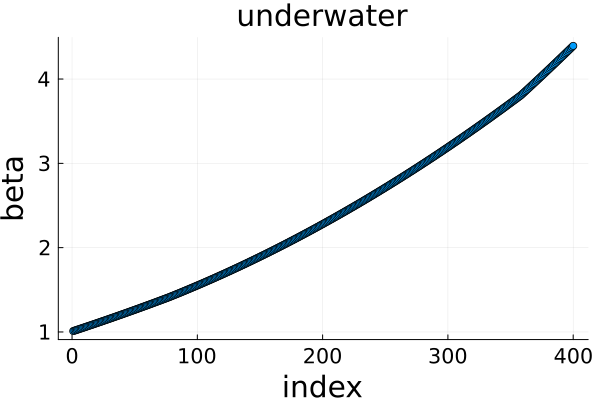

In [6]:
xdata = 1:length(offquants.state_scales)
ydata = offquants.state_scales
return scatter(xdata, ydata, legend=false, xlabel="index", ylabel="beta", title = "underwater", xguidefontsize = 20, yguidefontsize = 20, xtickfontsize = 14, ytickfontsize = 14, titlefontsize = 20, linewidth = 3.0)

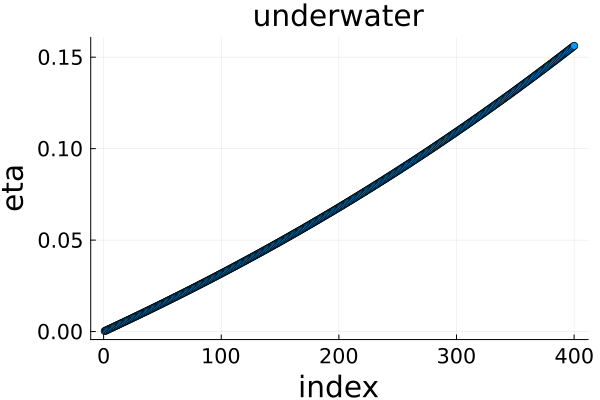

In [7]:
xdata = 1:length(offquants.error_scales)
ydata = offquants.error_scales
return scatter(xdata, ydata, legend=false, xlabel="index", ylabel="eta", title = "underwater", xguidefontsize = 20, yguidefontsize = 20, xtickfontsize = 14, ytickfontsize = 14, titlefontsize = 20, linewidth = 3.0)

Let us now define the scheduling function below based on the offline computed quantities.

Lets generate the scheduling function based on the offline computed quantities.

In [8]:
δ = generate_schedule(Luw, offquants)

(::SafeSelfTriggered.var"#scheduling_fun#60"{OfflineQuantities, SafeSelfTriggered.LinearImpulsiveSystem{Float64}}) (generic function with 1 method)

Let us compute a safe upper bound on the trigger time interval for a randomly sampled state and control inside the invariant set.

In [9]:
sampling_scale = rand();
comb_state = sampling_scale*real.(offquants.invariant.generators*(rand(MersenneTwister(0), Complex{Float64}, size(offquants.invariant.scale_vector)) .*offquants.invariant.scale_vector))
x = comb_state[1:4]
u = [comb_state[5]]
# compute scheduling bound
tmax = δ(x, u)
println("upper time bound = ", tmax)

upper time bound = 0.126


Let us use Girard's Algorithm (below reference) to verify the above schedule using the same time step as used for computing offline quantities.   
*Girard, Antoine. "Reachability of uncertain linear systems using zonotopes." HSCC. Vol. 3414. 2005.*

In [10]:
verifun = generate_verifier(Luw, T, offquants.time_step)
verifun(x, u, tmax)

true

Let us plot the schedules computed by the scheduling function vs the measure of size of the states and controls with respect to the invariant set.  It can be plotted by a function which has the following syntax.
```julia
plot_scheduling_function(Q::OfflineQuantities; title::String = "") 
```
- `Q`: OfflineQuantities
- `title`: (optional named argument) title of the plot

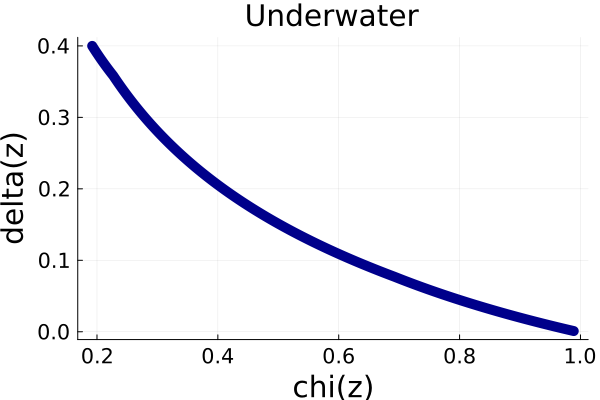

In [11]:
plot_scheduling_function(offquants; title = "Underwater")

Let us compare the computation time required to verify schedules computed by our algorithm to the time of computing the schedules.  The function `compare_computation_times` returns computation times by both algorithms and also the computed scheduling bounds.  It has syntax
```julia
compare_computation_times(number_points::Integer, L::SampledLinearSystem{<:Real}, T::Matrix{<:Real}, Q::OfflineQuantities; sampling_region_scale::Real = 1.0, seed = 1)
```
- `number_points`: number of randomly sampled points for which computation times are compared
- `L`: Sampled Linear System
- `T`: Matrix specifying safety bounds
- `Q`: Offline quantities 
- `sampling_region_scale`: (optional named argument) fraction of the invaraint set where points are sampled.  

In [14]:
(schedules, t1, t2) = compare_computation_times(100000, Luw, T, offquants; sampling_region_scale = 1);
println("speedup is ", t2/t1)
(schedules, t1, t2) = compare_computation_times(100000, Luw, T, offquants; sampling_region_scale = 0.5);
println("speedup is ", t2/t1)
(schedules, t1, t2) = compare_computation_times(100000, Luw, T, offquants; sampling_region_scale = 0.25);
println("speedup is ", t2/t1)
(schedules, t1, t2) = compare_computation_times(100000, Luw, T, offquants; sampling_region_scale = 0.1);
println("speedup is ", t2/t1)

speedup is 106.86244909386781
speedup is 

141.91032421960568


speedup is 142.27828108573587
speedup is 

136.6439235620596
